Importar las librerias necesarias

In [23]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import fuzzywuzzy
import re

import os

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import missingno as msno 

In [4]:
bank_info = pd.read_csv('../bank-additional_bank-additional-full.csv', sep= ';')
# bank-additional_bank-additional-full.csv
# /Users/betancle/1- Projects/Nuclio TFM/Trabajo_Final_Master-TFM-/bank-additional_bank-additional-full.csv

In [5]:
bank_info.sample(n = 10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
25259,45,unemployed,single,professional.course,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
2080,40,housemaid,single,university.degree,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
34682,33,blue-collar,single,basic.9y,unknown,yes,no,cellular,may,thu,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,no
40351,31,student,single,university.degree,no,no,no,cellular,aug,tue,...,4,6,2,success,-1.7,94.027,-38.3,0.899,4991.6,yes
35838,35,technician,divorced,professional.course,no,no,no,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.259,5099.1,yes
17155,60,retired,married,basic.6y,unknown,no,no,cellular,jul,fri,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18924,41,unknown,married,unknown,no,yes,yes,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.970,5228.1,no
1873,25,blue-collar,married,basic.9y,no,yes,no,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
26492,46,entrepreneur,married,unknown,unknown,yes,no,cellular,nov,thu,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no
22236,29,admin.,single,high.school,no,yes,no,cellular,aug,thu,...,3,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,yes


# EDA

Cúal son las variables númericas?

In [8]:
list(bank_info.select_dtypes('number').columns)

for i in list(bank_info.select_dtypes('number').columns):
    print(i)

age
duration
campaign
pdays
previous
emp.var.rate
cons.price.idx
cons.conf.idx
euribor3m
nr.employed


Cúal son las variables categoricas?

In [7]:
list(bank_info.select_dtypes('object').columns)

for i in list(bank_info.select_dtypes('object').columns):
    print(i)

job
marital
education
default
housing
loan
contact
month
day_of_week
poutcome
y


Más información sobre las columnas. 

Parece que no hay campos únicos que pueden ser identificadores.

In [10]:
bank_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Duplicados, nulos, y outliers

Usando describe() para ver información sobre los valores númericos. Hay que notar que 999 días en "pdays" es un valor nulo porque es la primera vez que contactan el cliente.

In [10]:
bank_info.describe().round(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10


Hay duplicados. Pero porque es información categórica y la población es grande, hay una alta probabilidad que haya personas con las mismas caracteristicas.

In [22]:
bank_info[bank_info.duplicated()].sort_values(by = 'age')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
36951,45,admin.,married,university.degree,no,no,no,cellular,jul,thu,...,1,999,0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,yes
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


No hay nulos en la forma tradicional. Cada celda tiene algo.

In [11]:
bank_info.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Parece que el valor 999 tambíen está utilizado por personas que ya han sido contactados.

In [12]:
bank_info[['pdays','previous']].value_counts()

pdays  previous
999    0           35563
       1            3696
       2             349
3      1             250
6      1             220
                   ...  
13     3               1
11     4               1
2      5               1
12     4               1
999    6               1
Name: count, Length: 96, dtype: int64

Es el valor más utilizado. Hay que clarificar que significa el 999, si tambíen significa que ha sido mucho tiempo desde el último contacto.

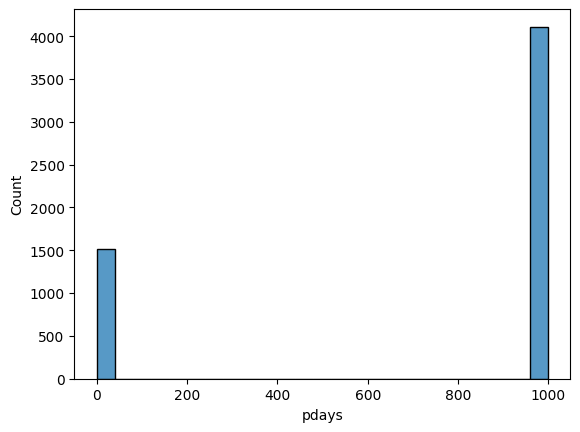

In [37]:
fig = sns.histplot(
    data=bank_info.query('previous > 0'), 
    x="pdays",
    bins= 25
    )


Hay gente que han contactado bastante, pero la gran mayoría tienen menos de 10-11 intentos.

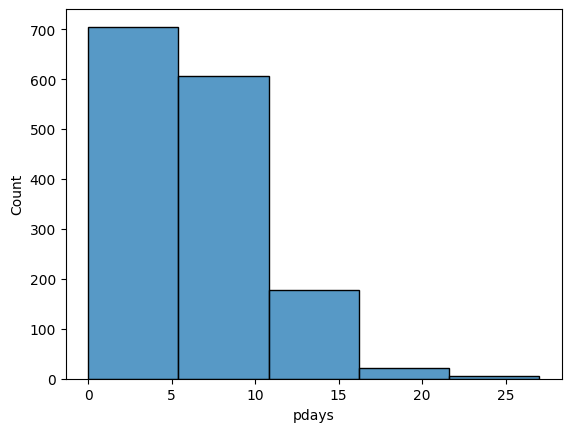

In [38]:
fig = sns.histplot(
    data=bank_info.query('previous > 0 & pdays != 999'), 
    x="pdays",
    bins= 5
    )


El máximo que no es 999 días es 27.

In [13]:
bank_info.query('pdays != 999')['pdays'].describe().round(2)

count    1515.00
mean        6.01
std         3.82
min         0.00
25%         3.00
50%         6.00
75%         7.00
max        27.00
Name: pdays, dtype: float64

Edades son valores típicas.

In [14]:
bank_info['age'].value_counts()

age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64

In [15]:
bank_info['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64